In [1]:
import numpy as np
from scipy.io.wavfile import write
from scipy.special import expit

import matplotlib.pyplot as plt

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
import ipywidgets as widgets

In [4]:
def generate_sound(duration, attack_duration, release_duration, slope_attack, slope_release, sr = 44100 ):

    # Generowanie szumu białego
    num_samples = int(sr * duration)
    white_noise = np.random.normal(0, 1, num_samples)
    
    # Tworzenie funkcji obwiedni (sigmoidalnej)
    time = np.linspace(0, duration, num_samples)

    # Create modified envelope with slope parameter
    attack = expit((time - attack_duration / 2) * slope_attack / attack_duration)
    release = expit((duration - time - release_duration / 2) * slope_release / release_duration)
    
    envelope = attack * release
    
    modulated_noise = white_noise * envelope
    modulated_noise = modulated_noise / np.max(np.abs(modulated_noise))

    return modulated_noise, envelope, time

In [5]:
def update_envelope(attack_duration, release_duration, attack_slope, release_slope):
    duration = 0.5
    modulated_noise, envelope, time = generate_sound(duration, attack_duration, release_duration, attack_slope, release_slope)
    
    fig, ax = plt.subplots(2,1, figsize=(12, 6))
    ax[0].plot(time, envelope)
    librosa.display.waveshow(modulated_noise, sr=sr, alpha=0.8, ax=ax[1])
    plt.title("Waveform")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()
    
    display(Audio(modulated_noise, rate=sr))

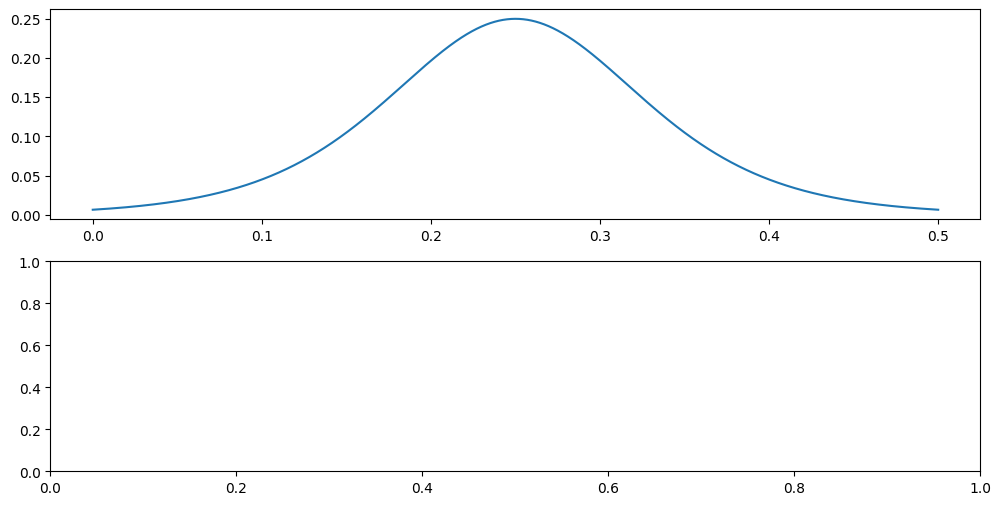

Output()

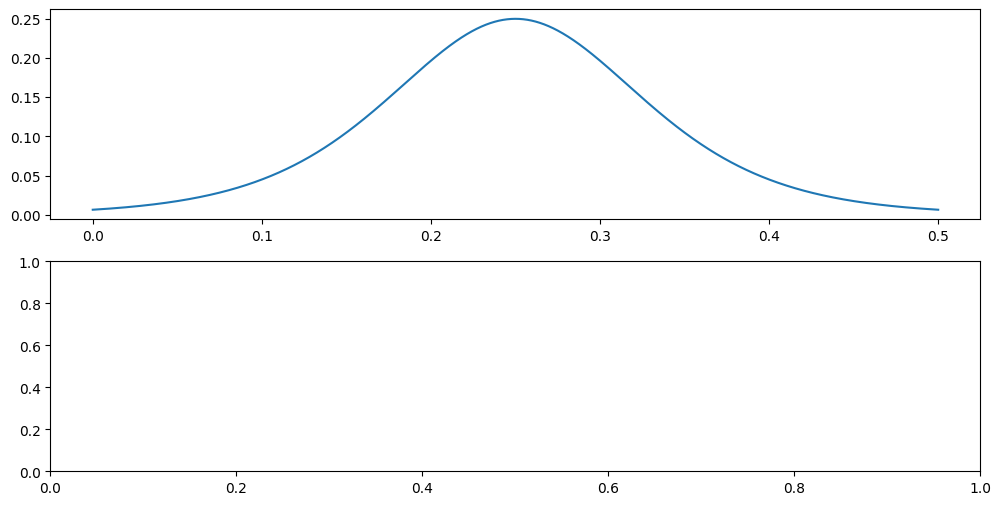

In [6]:
attack_duration_slider = widgets.FloatSlider(value=0.5, min=0.05, max=1.0, step=0.05, description="Attack Dur:")
release_duration_slider = widgets.FloatSlider(value=0.5, min=0.05, max=1.0, step=0.05, description="Release Dur:")
attack_slope_slider = widgets.FloatSlider(value=10, min=1, max=20, step=1, description="Attack Slope:")
release_slope_slider = widgets.FloatSlider(value=10, min=1, max=20, step=1, description="Release Slope:")

# Link sliders to update function
widgets.interactive(update_envelope, 
                    attack_duration=attack_duration_slider, 
                    release_duration=release_duration_slider, 
                    attack_slope=attack_slope_slider, 
                    release_slope=release_slope_slider)

# Display sliders
output = widgets.interactive_output(
    update_envelope,
    {
        "attack_duration": attack_duration_slider,
        "release_duration": release_duration_slider,
        "attack_slope": attack_slope_slider,
        "release_slope": release_slope_slider,
    },
)

# Display sliders and output together
ui = widgets.VBox([attack_duration_slider, release_duration_slider, attack_slope_slider, release_slope_slider])
display(ui, output)